Not done yet & to try:

- add constant terms to QAOA
- have a 2nd check at T operation

In [3]:
#BASE
import networkx as nx
from collections import Counter, defaultdict, namedtuple
from itertools import product
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm
import numpy as np

#ML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as CK
from sklearn.preprocessing import StandardScaler
from sklearn.utils.optimize import _check_optimize_result
from scipy.optimize import minimize

#QUANTUM
from qiskit import Aer, QuantumCircuit, execute

#VIZ
from matplotlib import pyplot as plt

#Set global parameters
s_eigenvalues = [0,1]
penalty = 2
shots = 1000

#Set graph instance & its complement
E = [(0,1), (1,2), (0,2), (2,3), (2,4)]; N = 5
G = nx.Graph()
G.add_nodes_from(range(N))
G.add_edges_from(E)
G_comp = nx.complement(G)

In [45]:
#Functions

def draw_graph(G):
    
    G_comp = nx.complement(G)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
    axes[0].set_title("GRAPH")
    axes[1].set_title("COMPLEMETARY GRAPH")
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,ax=axes[0],pos=pos)
    pos = nx.circular_layout(G_comp)
    nx.draw_networkx(G_comp,ax=axes[1],node_color="r",pos=pos)

def s2z(configuration):
    
    return [1-2*s for s in configuration]

def z2s(s):
    
    return [(1-z)/2 for z in configuration]

def str2list(s):
    
    l = []
    skip=False
    for x in s:
        if skip==True:
            skip=False
            continue
        if x == "-":
            l.append(-1)
            skip=True
        if x != "-":
            l.append(int(x))
    return l

def evaluate_cost(configuration, penalty=penalty, basis=None):
    
    '''
    configuration: eigenvalues
    '''
    
    cost=0
    if basis=="S":
        cost = -sum(configuration)
        for edge in G_comp.edges:
            cost += penalty*(configuration[edge[0]]*configuration[edge[1]])            
    elif basis=="Z":          
        cost = -(len(configuration) - sum(configuration))/2 
        for edge in G_comp.edges:
            cost += penalty/4*(1-configuration[edge[0]])*(1-configuration[edge[1]])
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
    return cost

def classical_solution(basis=None, show_top=None):  
    
    '''
    Runs through all 2^n possible configurations and estimates how many max cliques there are and plots one
    '''
    
    results = {}
    
    if basis=="S":
        eigenvalues = s_eigenvalues #[0, 1] i.e. eigenvalues for |0> ad |1> respectively
    elif basis=="Z": 
        eigenvalues = s2z(s_eigenvalues) #[1,-1] i.e. eigenvalues for |0> ad |1> respectively
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')
        
    eigen_configurations = list(product(eigenvalues, repeat=len(G)))
    for eigen_configuration in tqdm(eigen_configurations):
        results[eigen_configuration] = evaluate_cost(eigen_configuration, basis=basis)
    
    print('All possible solutions: \n')
    sol = pd.DataFrame(np.unique(list(results.values()), return_counts = True)).T
    sol.columns=["energy","occurrencies"]
    sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)
    if show_top is not None:
        print(sol.head(show_top))
    else:
        print(sol)
    d = dict((k, v) for k, v in results.items() if v == np.min(list(results.values())))
    print(f'\nThere are {len(d)} MAXCLIQUE(S) with eigenvalues configuration(s) in basis \"{basis}\": {d}')
    
    fig = plt.subplot(1, 2, 1)
    val, counts = np.unique(list(results.values()), return_counts = True)
    plt.bar(val, counts)
    plt.xlabel('Energy')
    plt.ylabel('Counts')
    plt.title('Statistics of solutions')

    fig = plt.subplot(1, 2, 2)
    plt.title('MaxClique')
    colors = list(d.keys())[0]
    pos = nx.circular_layout(G)
    nx.draw_networkx(G, node_color=colors, node_size=200, alpha=1, pos=pos)
    
def quantum_algorithm(gamma, beta, penalty):
    
    qc = QuantumCircuit(N,N)
    qc.h(range(N))

    for edge in G_comp.edges: 
        qc.rzz(gamma*penalty/2, edge[0], edge[1])
        qc.rz(-gamma*penalty/2, edge[0]) 
        qc.rz(-gamma*penalty/2, edge[1]) 
        
    for i in G.nodes:
        qc.rz(gamma, i) 
        
    qc.rx(2*beta, range(N)) 
    
    meas = QuantumCircuit(N,N)
    meas.barrier(range(N))
    meas.measure(range(N), range(N))

    return qc + meas
    
def QAOA(gamma, beta, penalty=penalty, shots=shots, basis="S"):
    
    '''
    Applies QAOA
    '''

    backend = Aer.get_backend("qasm_simulator")
    qc = quantum_algorithm(gamma, beta, penalty)
    simulate = execute(qc, backend=backend, shots=shots)
    results = simulate.result()
    extimated_f1 = 0
    counts = results.get_counts()
    pretty_counts = {k[::-1]:v for k,v in counts.items()} 
    if basis=="S":
        pass
    elif basis=="Z":
        pretty_counts = {"".join([str(x) for x in s2z([int(x) for x in k])]):v for k,v in pretty_counts.items()}
    else:
        raise ValueError('Basis should be specified: it must one of ["S","Z"]')

    for configuration in pretty_counts:
        prob_of_configuration = pretty_counts[configuration]/shots
        extimated_f1 += prob_of_configuration*evaluate_cost(str2list(configuration), basis=basis)
    
    return extimated_f1, pretty_counts

def grid_search(num_params, penalty=penalty, shots=shots, show_plot=True):

    QAOA_results = []
    Point = namedtuple("Point", "gamma beta f1")
    lin = np.linspace(0, np.pi, num_params)
    params = np.array(list((product(lin, repeat = 2))))
    
    X = np.unique(params[:,0])
    Y = np.unique(params[:,1])
    X, Y = np.meshgrid(X, Y)
    Q = np.zeros((len(X),len(X)))
    
    for i,j in tqdm(list(product(range(len(X)),repeat=2))):
        Q[i,j], _ = QAOA(X[i,j],Y[i,j], penalty=penalty, shots=shots, basis="S")
    
    if show_plot:

        plt.imshow(Q, extent = [0, np.pi, np.pi, 0])
        plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
        plt.xticks(fontsize = 15)
        plt.yticks(fontsize = 15)

        cb = plt.colorbar()
        plt.xlabel(r'$\gamma$', fontsize=20)
        plt.ylabel(r'$\beta$', fontsize =20)
        cb.ax.tick_params(labelsize=15)
        
        points = [Point(*x) for x in np.dstack((X,Y,Q)).reshape(-1,3)]
        
        return points
    
def plot_distribution(freq_dict):

    sorted_freq_dict = dict(sorted(freq_dict.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: 'g' for key in sorted_freq_dict}
    plt.figure(figsize=(12,6))
    plt.xlabel("configuration")
    plt.ylabel("counts")
    plt.xticks(rotation='vertical')
    plt.bar(sorted_freq_dict.keys(), sorted_freq_dict.values(), width=0.5, color = color_dict.values())
    
#def plot_f1_landscape(params, f1):
#    
#    fig = plt.figure()

#    # Make data.
#    X = np.unique(params[:,0])
#    Y = np.unique(params[:,1])
#    X, Y = np.meshgrid(X, Y)
#    Z = np.reshape(f1, (len(X), len(Y)))

    # Plot the surface.
#    plt.imshow(Z, extent = [0, np.pi, np.pi, 0])
#    plt.title('Grid Search: [{} x {}]'.format(len(X), len(X)))
#    plt.xticks(fontsize = 15)
#    plt.yticks(fontsize = 15)
    
#    cb = plt.colorbar()
#    plt.xlabel(r'$\gamma$', fontsize=20)
#    plt.ylabel(r'$\beta$', fontsize =20)
#    cb.ax.tick_params(labelsize=15)
    
def spectrum_vs_penalty(penalty_min=-2, penalty_max=3, penalty_step=0.5, show_plot=True, basis="S"):
    
    configuration_energies = defaultdict(list)
    penalties=np.arange(penalty_min, penalty_max, penalty_step)
    
    if basis == "S":
        eigenvalues = s_eigenvalues
    elif basis=="Z":
        eigenvalues = s2z(s_eigenvalues)

    for eigen_configuration in product(eigenvalues, repeat = len(G)):
        for penalty in penalties:
            configuration_energies[str(eigen_configuration)].append(evaluate_cost(str2list(eigen_configuration), penalty, basis=basis))

    degeneracies_df = pd.DataFrame(sorted(Counter([v[-1] for k,v in configuration_energies.items()]).items(), key=lambda item: item[0], reverse=False))
    degeneracies_df.columns=["energy","eigenstates"]

    if show_plot:

        for k, v in configuration_energies.items():
            plt.plot(penalties, v, label = k, marker="o")
            plt.xlabel("penalty")
            plt.ylabel("cost")
            plt.legend(title="eigen_configuration",bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    return degeneracies_df, configuration_energies

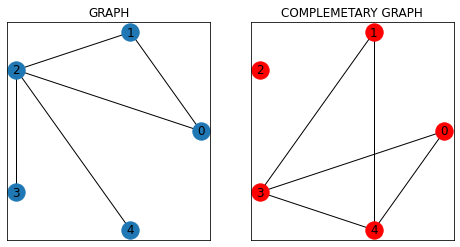

In [39]:
draw_graph(G)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<?, ?it/s]


All possible solutions: 

   energy  occurrencies  frequency
0    -3.0           1.0        3.0
1    -2.0           5.0       16.0
2    -1.0          10.0       31.0
3     0.0           8.0       25.0
4     1.0           2.0        6.0
5     2.0           2.0        6.0
6     3.0           2.0        6.0
7     5.0           1.0        3.0
8     6.0           1.0        3.0

There are 1 MAXCLIQUE(S) with eigenvalues configuration(s) in basis "Z": {(-1, -1, -1, 1, 1): -3.0}


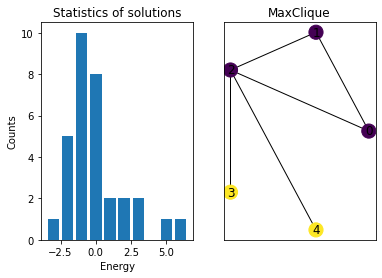

In [40]:
classical_solution(basis="Z")

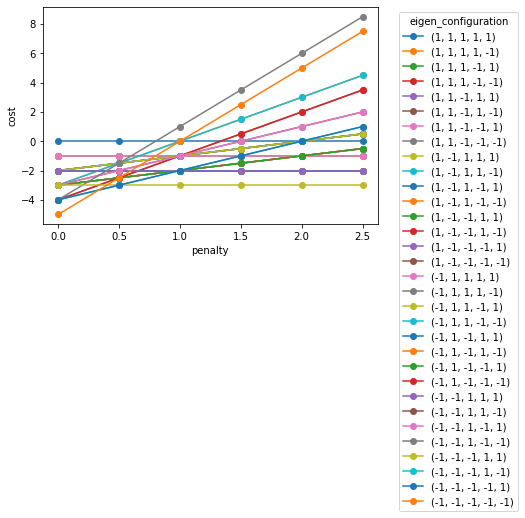

The degeneracies at penalty_max are:


,energy,eigenstates
0,-3.0,1
1,-2.0,5
2,-1.0,5
3,-0.5,5
4,0.0,1
5,0.5,5
6,1.0,2
7,2.0,2
8,3.5,2
9,4.5,2


In [46]:
degeneracies_df, configuration_energies = spectrum_vs_penalty(penalty_min=0, penalty_max=3, penalty_step=0.5, basis="Z")
print("The degeneracies at penalty_max are:")
degeneracies_df

### Gaussian Process to approximate the f1 landscape of a graph

Generates $N_{train}$ points selected randomly on a grid $[gamma-extremes] \times [beta-extremes]$, trains a sklearn Gaussin Process Regressor with a kernel defined by kernel and tests it on $N_{test}^2$ samples uniformly picked on a grid $[0, max(gamma, betas)] \times [0, max(gamma, betas)] $. Result is compared to grid search

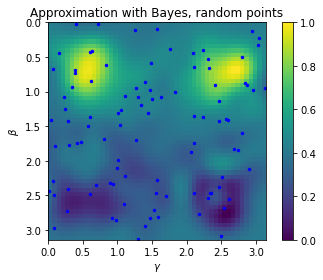

In [83]:
N_train = 100
N_test = 50
gamma_extremes = [0, np.pi]
beta_extremes = [0, np.pi]
X_train = []; y_train = []

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X) 
    y_train.append(Y)

kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0, normalize_y = True)
gp.fit(X_train, y_train)

X_lin = np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test) 
X_test_grid = list(product(X_lin, X_lin))

predicted_means = gp.predict(X_test_grid) 
res = np.reshape(predicted_means, (N_test, N_test)).T #extremes is (left,right,bommot,top)
X_train = np.array(X_train)
plt.title('Approximation with Bayes, random points')
plt.imshow(res, extent = gamma_extremes + beta_extremes[::-1]) #extremes is (left,right,bommot,top) [0,np.pi,np.pi,0]
plt.scatter(X_train[:,0], X_train[:,1], s=6, c='b')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$\beta$')
plt.colorbar()

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:27<00:00, 33.06it/s]


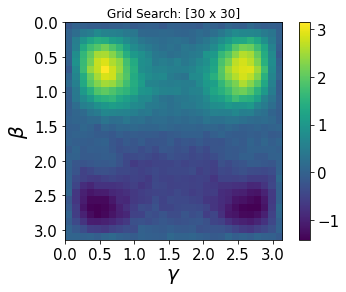

In [110]:
#To confront with
points = grid_search(30)

In [ ]:
optimal_point = points[np.argmin([p.f1 for p in points])]
optimal_f1 = optimal_point.f1 #chiaramente è difficile aspettarsi che sia il minimo esatto, perché è un valore di aspettazione
optimal_params = [optimal_point.gamma, optimal_point.beta]

### Let's see how the QAOA performs on the "optimal" parameters found the by the grid search in the previous cell. Two criteria must be taken into account:

- time
- quality of solution (we could use as a FEM, the approximation ration)

,eigen_configuration,energy,occurrencies,frequency
0,-1-1-111,-3.0,1047,10.0
1,11-11-1,-2.0,1041,10.0
2,11-1-11,-2.0,995,10.0
3,1-1-111,-2.0,785,8.0
4,-11-111,-2.0,784,8.0
5,11-111,-1.0,622,6.0
6,-1-1111,-2.0,585,6.0
7,111-11,-1.0,528,5.0
8,1111-1,-1.0,506,5.0
9,1-1111,-1.0,404,4.0


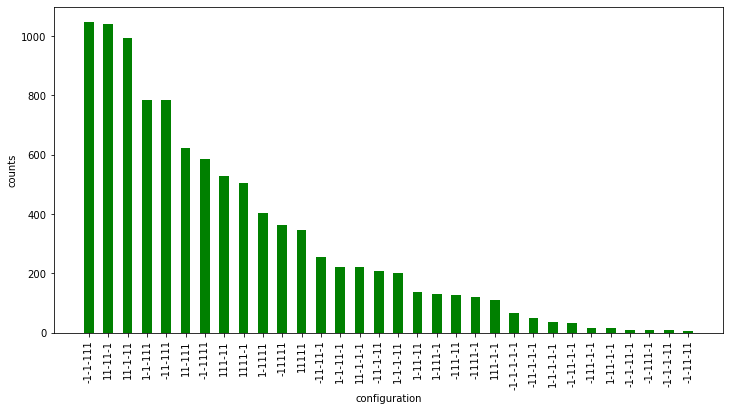

In [122]:
#lo stato cercato è sempre della top 3 ma non è detto sia sempre il primo... sentire D e S

basis="Z"

extimated_f1, pretty_counts = QAOA(*optimal_params, shots=10000, basis=basis) #prendo un numero molto grande di shots per stabilizzare la distribuzione (legge grandi numeri)
plot_distribution(pretty_counts)
sol = pd.DataFrame(dict(sorted(pretty_counts.items(), key=lambda item: item[1], reverse=True)),index=[0]).T.reset_index()
sol.columns=["eigen_configuration","occurrencies"]
sol["frequency"]=round(sol["occurrencies"]/sol["occurrencies"].sum()*100,0)#.head(3)
sol["energy"]=sol["eigen_configuration"].apply(lambda x: evaluate_cost(str2list(x),basis=basis))
sol=sol[["eigen_configuration","energy","occurrencies","frequency"]]
sol.head(10)

### Bayesian Optimization to find the minimum of the f1 of a graph


In [123]:
#Allows to change max_iter (see cell below) as well as gtol. It can be straightforwardly extended to other parameters
class MyGaussianProcessRegressor(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min
    
def rescaler(x, min_old=0, max_old=np.pi, min_new=0, max_new=1):
    
    x_sc = min_new + (max_new - min_new)/(max_old - min_old)*(x - min_old)
    
    return x_sc

In [124]:
acq_function = 'EI'
N_train = 10
N_test = 100
iterations = 100
gamma_extremes = [0, np.pi]; beta_extremes = [0, np.pi]
X_train = []; y_train = []

#seed
my_seed = 42
np.random.seed(my_seed)

for i in range(N_train):
    X = [np.random.uniform(*gamma_extremes), np.random.uniform(*beta_extremes)]
    X_train.append(X)
    Y, _ = QAOA(*X)
    y_train.append(Y)

X= np.linspace(0, np.max([gamma_extremes, beta_extremes]), N_test)
X_test = list(product(X, X))

X_train = rescaler(np.array(X_train)).tolist()
X_test = rescaler(np.array(X_test)).tolist()

#create gaussian process and fit training data
kernel = CK(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = MyGaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha = 1e-2, normalize_y = True, max_iter = 50000)
gp.fit(X_train, y_train)

#At each iteration we calculate the best point where to sample from
sample_points = []   #We save every point that was chosen to sample from

for i in range(iterations):
        
        # Test GP
        new_mean, new_sigma = gp.predict(X_test, return_std=True)
        
        #New_mean and new_sigma both are (N_test**2, ) arrays not reshaped yet
        mean_max = np.max(new_mean)
        mean_min = np.min(new_mean)
        
        #Now calculate acquisitition fn as the cumulative for every point centered around the maximum
        cdf = norm.cdf(x = new_mean, loc =  mean_max, scale = new_sigma)
        pdf = norm.pdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        #The qdf is instead the probability of being lower then the lowest value of the mean (where we wanto to pick the next_value)
        qdf = 1-norm.cdf(x = new_mean, loc =  mean_min, scale = new_sigma)
    
        if acq_function == 'PI':
            #Next values is calculated as so just because argmax returns a number betwenn 1 and n_test instead of inside the interval
            value = np.argmax(qdf)
            next_point = X_test[value]
            
        if acq_function == 'EI':
            alpha_function = (new_mean - mean_min - 0.001)*qdf + new_sigma*pdf
            #argmax is a number between 0 and N_test**-1 telling us where is the next point to sample
            argmax = np.argmax(np.round(alpha_function, 3))
            next_point_normalized = X_test[argmax]
        
        next_point = rescaler(np.array(next_point_normalized), min_old=0, max_old=1, min_new=0, max_new=np.pi)
        X_train.append(next_point_normalized)
        y_next_point,_ = QAOA(*next_point)
        y_train.append(y_next_point)
        print(i, next_point, y_next_point)

        gp.fit(X_train, y_train)
        sample_points.append(next_point)
            
print('reached limit')

0 [0.        2.0943951] 0.07799999999999999
1 [0.82506474 2.34826118] -0.6060000000000001
2 [1.61839622 1.65012947] -0.11299999999999995
3 [2.50692747 2.60212725] -1.1010000000000002
4 [3.14159265 2.34826118] -0.03899999999999998
5 [2.22132814 3.14159265] -0.10099999999999998
6 [0.50773215 2.72906028] -1.3699999999999999
7 [0.50773215 2.76079354] -1.388
8 [0.47599889 2.63386051] -1.3900000000000001
9 [0.47599889 2.66559377] -1.356
10 [0.47599889 2.66559377] -1.4429999999999998
11 [0.50773215 2.72906028] -1.3579999999999999
12 [0.47599889 2.66559377] -1.4509999999999998
13 [0.47599889 2.63386051] -1.3559999999999999
14 [0.47599889 2.66559377] -1.325
15 [3.14159265 3.14159265] 0.021999999999999978
16 [0.47599889 2.66559377] -1.333
17 [0.47599889 2.66559377] -1.426
18 [0.47599889 2.66559377] -1.346
19 [0.47599889 2.66559377] -1.4149999999999998
20 [0.47599889 2.66559377] -1.417
21 [0.47599889 2.66559377] -1.3719999999999999
22 [0.47599889 2.66559377] -1.41
23 [0.47599889 2.66559377] -1.34

Optimal f1: -1.404


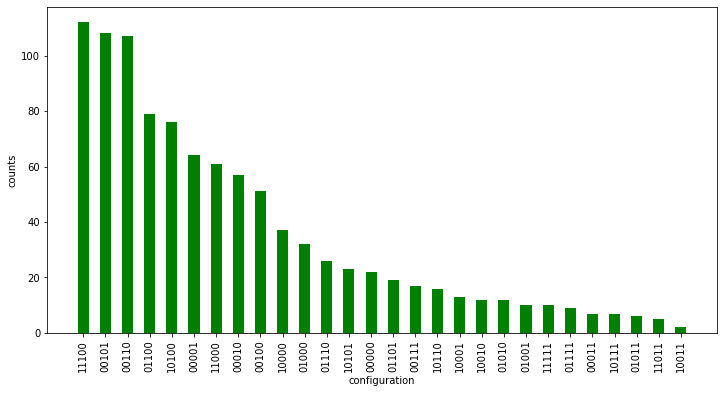

In [127]:
optimal_points = sample_points[-1]
optimal_f1, counts = QAOA(*optimal_points,shots=1000, basis="S")
print(f"Optimal f1: {optimal_f1}")
plot_distribution(counts)

100%|████████████████████████████████████████████████████████████████████████████| 40000/40000 [54:28<00:00, 12.24it/s]


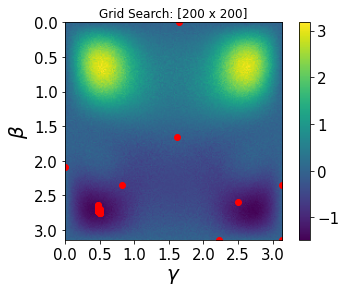

In [128]:
points = grid_search(200, shots=1000)
sample_points = np.array(sample_points)
plt.scatter(sample_points[:,0], sample_points[:,1], c = 'r')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()